In [31]:
#Importing packages
#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [10]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [11]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:\\Users\\A\\Desktop\\Bioactive\\HSV-3")

In [12]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [13]:
Cv_optuna= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [14]:
#Reading the data
ML_data= pd.read_csv("./ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original_data.csv',index_col=0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(1655, 3904)


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
cid,,,,,,,,,,,,,,,,,,,,,
3011383,294.24,8.654118,20.4589,35.6472,21.0000,39.4645,0.601732,1.048447,0.617647,1.160721,...,0.0,0.0,0.0,6.0,16.0,0.842105,9.0,0.473684,15.362291,8.246211
53357718,377.38,8.203913,29.1043,46.8616,30.6195,52.3744,0.632702,1.018730,0.665641,1.138574,...,0.0,0.0,6.0,10.0,20.0,0.769231,6.0,0.230769,18.627936,9.949874
135398513,225.24,8.342222,16.8318,28.1417,16.6762,31.3653,0.623400,1.042285,0.617637,1.161678,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
446727,333.16,10.411250,20.8028,33.3708,21.2046,36.3764,0.650088,1.042838,0.662644,1.136762,...,0.0,0.0,0.0,0.0,16.0,0.842105,6.0,0.315789,18.906056,6.504435
168280858,434.50,7.241667,34.1893,61.0360,36.3412,69.3675,0.569822,1.017267,0.605687,1.156125,...,0.0,0.0,0.0,5.0,18.0,0.620690,10.0,0.344828,17.291616,9.539392


In [15]:
Raw_data

,Activite,IsomericSMILES,Canonical_smiles
cid,,,
3011383,1,C1=C(N=C(N=C1OC[C@H](CO)OCP(=O)(O)O)N)N,Nc1cc(OC[C@H](CO)OCP(=O)(O)O)nc(N)n1
53357718,1,C1=CC=C(C=C1)CC(CP(=O)(O)O)OCCN2C=NC3=C(N=CN=C...,Nc1ncnc2c1ncn2CCOC(Cc1ccccc1)CP(=O)(O)O
135398513,1,C1=NC2=C(N1COCCO)N=C(NC2=O)N,Nc1nc2c(ncn2COCCO)c(=O)[nH]1
446727,1,C1[C@@H]([C@H](O[C@H]1N2C=C(C(=O)NC2=O)/C=C/Br...,O=c1[nH]c(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1...
168280858,1,CCN(CC)CC.CC(CN1C=NC2=C1N=C(NC2=O)N)(CO)OCP(=O...,CC(CO)(Cn1cnc2c(=O)[nH]c(N)nc21)OCP(=O)(O)O.CC...
...,...,...,...
60167465,0,C1CC1C#CC#CC2=CN(C(=O)NC2=O)[C@H]3C[C@@H]([C@H...,O=c1[nH]c(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1...
60167322,0,C1[C@@H]([C@H](O[C@H]1N2C=C(C(=O)NC2=O)C#CC#CC...,Nc1cccc(C#CC#Cc2cn([C@H]3C[C@H](O)[C@@H](CO)O3...
70683866,0,CCCCCCCCOC1=NC(=NC2=C1N=CN2/C=C\3/CC3(CO)CO)N,CCCCCCCCOc1nc(N)nc2c1ncn2/C=C1/CC1(CO)CO


In [16]:
#Data after feature selection (descriptors= 64）
print(ML_data.shape)
ML_data.head()

(1655, 194)


,s4_pathLength,SHED_DL,mindO,TIE,phLevel3,NdssC,nROR,minssCH2,IC5,F05[C-O],...,B10[C-F],T(N..S),MATS1v,P_VSA_LogP_5,B08[C-C],GATS5m,GATS8p,MATS7i,nCt,nRCOOR
cid,,,,,,,,,,,,,,,,,,,,,
3011383,0.187500,0.206340,0.762786,0.021785,0.00,0.000000,0.076923,0.248516,0.678617,0.186047,...,0.0,0.0,0.685877,0.094285,0.0,0.703365,0.302063,0.553284,0.000000,0.0
53357718,0.250000,0.484777,0.820012,0.023288,0.75,0.000000,0.076923,0.405045,0.749968,0.209302,...,0.0,0.0,0.548521,0.135835,1.0,0.606525,0.301601,0.591377,0.000000,0.0
135398513,0.000000,0.000000,0.820461,0.009111,0.00,0.153846,0.076923,0.491773,0.636705,0.069767,...,0.0,0.0,0.403068,0.203738,0.0,0.656244,0.452865,0.595804,0.000000,0.0
446727,0.229167,0.462054,0.827658,0.023375,0.50,0.230769,0.076923,0.405772,0.717092,0.186047,...,0.0,0.0,0.528303,0.027305,1.0,0.481643,0.388422,0.609791,0.000000,0.0
168280858,0.187500,0.156377,0.783192,0.060976,0.00,0.153846,0.076923,0.238515,0.629374,0.302326,...,0.0,0.0,0.335561,0.230518,0.0,0.572332,0.278270,0.398806,0.142857,0.0


# DT

In [18]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activite'].values
clf=DecisionTreeClassifier(random_state=0)

In [19]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.795340,0.003437
Accuracy_train,0.985015,0.000124
F1 Score,0.580840,0.006887
Precision,0.591134,0.007754
Recall,0.576805,0.008304
Roc_auc,0.727077,0.004652


In [20]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.793045,0.002909
Accuracy_train,0.985015,0.000124
F1 Score,0.577664,0.006179
Precision,0.583267,0.006239
Recall,0.577232,0.008254
Roc_auc,0.724921,0.004228


In [21]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth',3,5,1),
        'max_features' : trial.suggest_int("max_features",10,20,1),
        'min_samples_split':trial.suggest_int('min_samples_split',2,25,1)
    }
    model = DecisionTreeClassifier(**param,random_state=1)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-02 02:32:30,498] A new study created in memory with name: no-name-c2d16128-de77-47ff-bad2-40c6a0ca3402
[I 2023-11-02 02:32:32,043] Trial 0 finished with value: 0.7860960204454182 and parameters: {'max_depth': 4, 'max_features': 17, 'min_samples_split': 16}. Best is trial 0 with value: 0.7860960204454182.
[I 2023-11-02 02:32:32,159] Trial 1 finished with value: 0.7896155531215772 and parameters: {'max_depth': 4, 'max_features': 14, 'min_samples_split': 17}. Best is trial 1 with value: 0.7896155531215772.
[I 2023-11-02 02:32:32,267] Trial 2 finished with value: 0.7803614457831324 and parameters: {'max_depth': 4, 'max_features': 19, 'min_samples_split': 25}. Best is trial 1 with value: 0.7896155531215772.
[I 2023-11-02 02:32:32,378] Trial 3 finished with value: 0.7905724717050019 and parameters: {'max_depth': 4, 'max_features': 18, 'min_samples_split': 14}. Best is trial 3 with value: 0.7905724717050019.
[I 2023-11-02 02:32:32,490] Trial 4 finished with value: 0.787069003285870

In [22]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf =DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)

The best parameters are : 
{'max_depth': 5, 'max_features': 10, 'min_samples_split': 7}


In [23]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.799460,0.002527
Accuracy_train,0.828117,0.000653
F1 Score,0.438563,0.007708
Precision,0.718485,0.012126
Recall,0.321030,0.006977
Roc_auc,0.749329,0.004124


In [24]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [25]:
data_dt=ML_data[columns]
data_dt.to_csv("./data_dt.csv",sep=',')
X_DT=np.array(data_dt)

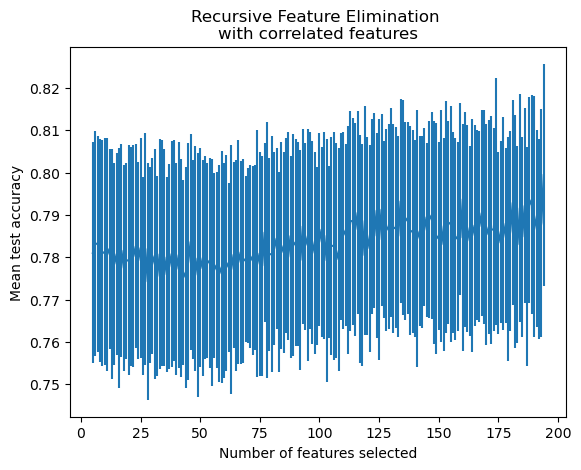

In [26]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [27]:
#Model4 （len(columns) descriptors）
Model4_clf=DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)
Model4_clf.fit(X_DT, y)
#Model4
Model4=Model_results(Model4_clf,X_DT,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.799460,0.002527
Accuracy_train,0.828117,0.000653
F1 Score,0.438563,0.007708
Precision,0.718485,0.012126
Recall,0.321030,0.006977
Roc_auc,0.749329,0.004124


In [28]:
Model4_clf=Model4_clf.fit(X_DT, y)
#Saving the final model
joblib.dump(Model4_clf, './DT.pkl')
DT= joblib.load(filename='./DT.pkl')

In [29]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./DT_model_data.csv",sep=',')
Model_data.columns = [['DecisionTree']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./DT_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/DT_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         DecisionTree                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.795340  0.003437  0.793045  0.002909  0.799460  0.002527   
Accuracy_train     0.985015  0.000124  0.985015  0.000124  0.828117  0.000653   
F1 Score           0.580840  0.006887  0.577664  0.006179  0.438563  0.007708   
Precision          0.591134  0.007754  0.583267  0.006239  0.718485  0.012126   
Recall             0.576805  0.008304  0.577232  0.008254  0.321030  0.006977   
Roc_auc            0.727077  0.004652  0.724921  0.004228  0.749329  0.004124   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.799460  0.002527  
Accuracy_train  0.828117  0.000653  
F1 Score        0.438563  0.007708  
Precision       0.718485  0.012126  
Recall          0.321030  0.006977  
Roc_auc         0.749329  0.004124

# LR

In [32]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activite'].values
clf=LogisticRegression(solver='liblinear',random_state=0)

In [33]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.804117,0.002863
Accuracy_train,0.834401,0.002084
F1 Score,0.506961,0.008287
Precision,0.669275,0.009801
Recall,0.413561,0.008650
Roc_auc,0.789365,0.004607


In [34]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.811601,0.002723
Accuracy_train,0.836938,0.000385
F1 Score,0.535056,0.007521
Precision,0.683442,0.008373
Recall,0.443427,0.007708
Roc_auc,0.823389,0.003716


In [35]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    logreg_c = trial.suggest_float("logreg_c", 1e-3,  1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio",0.1,1,log=False) 
    #penalty = trial.suggest_categorical("penalty",['l1','l2'])
    max_iter = trial.suggest_int("max_iter", 100,2000)
    model =LogisticRegression(C=logreg_c,
                              max_iter=max_iter,
                              l1_ratio=l1_ratio,
                              solver='liblinear',random_state=1)
    
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-02 10:54:53,241] A new study created in memory with name: no-name-fd6cf656-e550-4eb8-946f-dfce217b211a
[I 2023-11-02 10:54:54,934] Trial 0 finished with value: 0.8054395764877692 and parameters: {'logreg_c': 0.3177840006884068, 'l1_ratio': 0.7482920440979423, 'max_iter': 100}. Best is trial 0 with value: 0.8054395764877692.
[I 2023-11-02 10:54:55,230] Trial 1 finished with value: 0.7946812705366922 and parameters: {'logreg_c': 0.0651621545821569, 'l1_ratio': 0.23208030173540176, 'max_iter': 275}. Best is trial 0 with value: 0.8054395764877692.
[I 2023-11-02 10:54:55,529] Trial 2 finished with value: 0.7656188389923329 and parameters: {'logreg_c': 0.013108749615263334, 'l1_ratio': 0.411004654338743, 'max_iter': 854}. Best is trial 0 with value: 0.8054395764877692.
[I 2023-11-02 10:54:55,994] Trial 3 finished with value: 0.8145604235122309 and parameters: {'logreg_c': 1.7096232052870346, 'l1_ratio': 0.4772750629629653, 'max_iter': 1402}. Best is trial 3 with value: 0.814560423

In [36]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=LogisticRegression(C=study.best_params['logreg_c'],
                              max_iter=study.best_params['max_iter'],
                              l1_ratio=study.best_params['l1_ratio'],
                              solver='liblinear',
                              random_state=1)

The best parameters are : 
{'logreg_c': 2.716096342599398, 'l1_ratio': 0.6721127199864985, 'max_iter': 1125}


In [37]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.816377,0.002842
Accuracy_train,0.850158,0.000423
F1 Score,0.559839,0.007689
Precision,0.683254,0.008021
Recall,0.477738,0.008058
Roc_auc,0.824998,0.003798


In [38]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [39]:
data_lr=ML_data[columns]
data_lr.to_csv("./data_lr.csv",sep=',')
X_LR=np.array(data_lr)

In [40]:
data_lr

,s4_pathLength,SHED_DL,mindO,phLevel3,NdssC,nROR,minssCH2,F01[C-O],P_VSA_LogP_6,MATS4e,...,F07[N-P],VE1sign_A,C-026,JGI7,B10[C-F],P_VSA_LogP_5,GATS5m,GATS8p,nCt,nRCOOR
cid,,,,,,,,,,,,,,,,,,,,,
3011383,0.187500,0.206340,0.762786,0.00,0.000000,0.076923,0.248516,0.178571,0.269120,0.598341,...,0.333333,0.610664,0.000,0.674663,0.0,0.094285,0.703365,0.302063,0.000000,0.0
53357718,0.250000,0.484777,0.820012,0.75,0.000000,0.076923,0.405045,0.071429,0.019227,0.680481,...,0.000000,0.171217,0.000,0.420952,0.0,0.135835,0.606525,0.301601,0.000000,0.0
135398513,0.000000,0.000000,0.820461,0.00,0.153846,0.076923,0.491773,0.142857,0.210128,0.642412,...,0.000000,0.273781,0.000,0.551056,0.0,0.203738,0.656244,0.452865,0.000000,0.0
446727,0.229167,0.462054,0.827658,0.50,0.230769,0.076923,0.405772,0.214286,0.326979,0.535628,...,0.000000,0.214376,0.000,0.596244,0.0,0.027305,0.481643,0.388422,0.000000,0.0
168280858,0.187500,0.156377,0.783192,0.00,0.153846,0.076923,0.238515,0.142857,0.210128,0.546625,...,0.666667,0.072148,0.000,0.570230,0.0,0.230518,0.572332,0.278270,0.142857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60167465,0.322917,0.610049,0.847207,0.50,0.230769,0.076923,0.399687,0.214286,0.792401,0.607117,...,0.000000,0.234266,0.000,0.501281,0.0,0.027305,0.527486,0.387609,0.142857,0.0
60167322,0.385417,0.712393,0.858128,0.50,0.230769,0.076923,0.391515,0.214286,0.792401,0.620504,...,0.000000,0.251164,0.125,0.475317,0.0,0.078239,0.525791,0.376193,0.000000,0.0
70683866,0.000000,0.706734,0.000000,0.00,0.076923,0.000000,0.488176,0.142857,0.152672,0.613720,...,0.000000,0.216350,0.000,0.498261,0.0,0.156247,0.529736,0.340897,0.000000,0.0


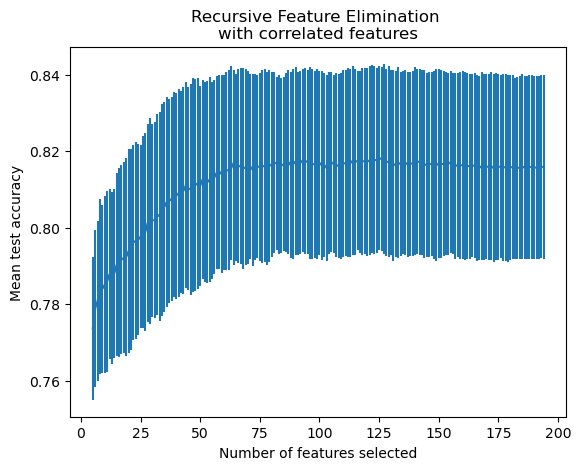

In [41]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [42]:
#Model4 （len(columns) descriptors）
Model4_clf=LogisticRegression(C=study.best_params['logreg_c'],max_iter=study.best_params['max_iter'],solver='liblinear',random_state=0)
#Model4
Model4=Model_results(Model4_clf,X_LR,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.824829,0.002825
Accuracy_train,0.848231,0.000380
F1 Score,0.581185,0.007494
Precision,0.707898,0.008140
Recall,0.497098,0.008078
Roc_auc,0.842713,0.003540


In [43]:
Model4_clf=Model4_clf.fit(X_LR, y)
#Saving the final model
joblib.dump(Model4_clf, './LogReg.pkl')
LogReg= joblib.load(filename='./LogReg.pkl')

In [44]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./LR_model_data.csv",sep=',')
Model_data.columns = [['LogisticRegression']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./LR_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         LogisticRegression                                          \
Model                     Model 1             Model 2             Model 3   
Values                       Mean        Se      Mean        Se      Mean   
Accuracy_test            0.804117  0.002863  0.811601  0.002723  0.816377   
Accuracy_train           0.834401  0.002084  0.836938  0.000385  0.850158   
F1 Score                 0.506961  0.008287  0.535056  0.007521  0.559839   
Precision                0.669275  0.009801  0.683442  0.008373  0.683254   
Recall                   0.413561  0.008650  0.443427  0.007708  0.477738   
Roc_auc                  0.789365  0.004607  0.823389  0.003716  0.824998   

Method                                        
Model                      Model 4            
Values                Se      Mean        Se  
Accuracy_test   0.002842  0.824829  0.002825  
Accuracy_train  0.000423  0.848231  0.000380  
F1 Score        0.007689  0.581185  0.007494  
Precision       0.008021  0.707898  0.008140  
Recall          0.008058  0.497098  0.008078  
Roc_auc         0.003798  0.842713  0.003540

# RF

In [45]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activite'].values
clf=RandomForestClassifier(random_state=0)

In [46]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.835945,0.002910
Accuracy_train,0.985008,0.000124
F1 Score,0.615045,0.007294
Precision,0.732424,0.008822
Recall,0.535299,0.008095
Roc_auc,0.857462,0.003409


In [47]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.844286,0.002614
Accuracy_train,0.985008,0.000124
F1 Score,0.625588,0.007158
Precision,0.767812,0.007984
Recall,0.532890,0.008256
Roc_auc,0.871309,0.003148


In [48]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators",100,1000,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",5,20,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    #max_features = trial.suggest_categorical("max_features",["log2","sqrt","auto"]) #字符型
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease",0,5,log=False) #浮点型
    model = RandomForestClassifier(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_impurity_decrease = min_impurity_decrease
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)

[I 2023-11-02 11:02:36,218] A new study created in memory with name: no-name-bdb4e624-c0ba-40ce-9c91-53c54046bfc8
[I 2023-11-02 11:02:48,094] Trial 0 finished with value: 0.7534757210660823 and parameters: {'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}. Best is trial 0 with value: 0.7534757210660823.
[I 2023-11-02 11:03:03,059] Trial 1 finished with value: 0.7534757210660823 and parameters: {'n_estimators': 481, 'max_depth': 15, 'max_features': 16, 'min_impurity_decrease': 4.4588650039103985}. Best is trial 0 with value: 0.7534757210660823.
[I 2023-11-02 11:03:36,729] Trial 2 finished with value: 0.7534757210660823 and parameters: {'n_estimators': 968, 'max_depth': 11, 'max_features': 25, 'min_impurity_decrease': 2.644474598764522}. Best is trial 0 with value: 0.7534757210660823.
[I 2023-11-02 11:03:53,596] Trial 3 finished with value: 0.7534757210660823 and parameters: {'n_estimators': 611, 'max_depth': 19, 'max_features': 6, 'mi

In [49]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

The best parameters are : 
{'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}


In [50]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.753476,0.000215
Accuracy_train,0.753474,0.000024
F1 Score,0.000000,0.000000
Precision,0.000000,0.000000
Recall,0.000000,0.000000
Roc_auc,0.500000,0.000000


In [51]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [52]:
data_rf=ML_data[columns]
data_rf.to_csv("./data_rf.csv",sep=',')
X_RF=np.array(data_rf)

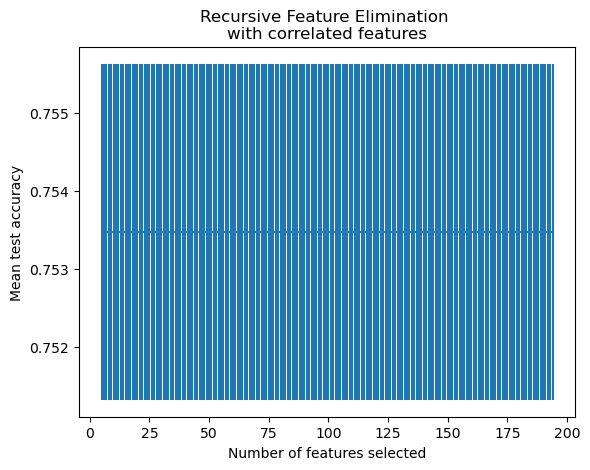

In [53]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [54]:
#Model4 （len(columns) descriptors）
Model4_clf=clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)
Model4_clf.fit(X_RF, y)
#Model4
Model4=Model_results(Model4_clf,X_RF,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.753476,0.000215
Accuracy_train,0.753474,0.000024
F1 Score,0.000000,0.000000
Precision,0.000000,0.000000
Recall,0.000000,0.000000
Roc_auc,0.500000,0.000000


In [55]:
Model4_clf=Model4_clf.fit(X_RF, y)
#Saving the final model
joblib.dump(Model4_clf, './RF.pkl')
RF= joblib.load(filename='./RF.pkl')

In [58]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./RF_model_data.csv",sep=',')
Model_data.columns = [['RandomForest']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./RF_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/RF_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         RandomForest                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.835945  0.002910  0.844286  0.002614  0.753476  0.000215   
Accuracy_train     0.985008  0.000124  0.985008  0.000124  0.753474  0.000024   
F1 Score           0.615045  0.007294  0.625588  0.007158  0.000000  0.000000   
Precision          0.732424  0.008822  0.767812  0.007984  0.000000  0.000000   
Recall             0.535299  0.008095  0.532890  0.008256  0.000000  0.000000   
Roc_auc            0.857462  0.003409  0.871309  0.003148  0.500000  0.000000   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.753476  0.000215  
Accuracy_train  0.753474  0.000024  
F1 Score        0.000000  0.000000  
Precision       0.000000  0.000000  
Recall          0.000000  0.000000  
Roc_auc         0.500000  0.000000

# xgboost

In [59]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activite'].values
clf=xgb.XGBClassifier(random_state=0)

In [60]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.837037,0.002648
Accuracy_train,0.985015,0.000124
F1 Score,0.631588,0.006563
Precision,0.714510,0.007137
Recall,0.570683,0.007999
Roc_auc,0.870746,0.003171


In [61]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.838484,0.002658
Accuracy_train,0.985015,0.000124
F1 Score,0.633966,0.006443
Precision,0.720798,0.007544
Recall,0.570695,0.007635
Roc_auc,0.872909,0.003166


In [62]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,1.0,step=0.1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, step=0.005),
        'n_estimators': trial.suggest_int("n_estimators",50,1000,1)
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param,random_state=1,n_jobs=8)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-02 14:13:48,445] A new study created in memory with name: no-name-9cb7f41d-af22-4028-9ee4-14c9062d7d04
[I 2023-11-02 14:16:15,190] Trial 0 finished with value: 0.8400547645125959 and parameters: {'lambda': 0.15676677195506075, 'alpha': 0.7257005721594281, 'colsample_bytree': 0.7, 'subsample': 0.7000000000000001, 'learning_rate': 0.0801, 'n_estimators': 664}. Best is trial 0 with value: 0.8400547645125959.
[I 2023-11-02 14:18:34,690] Trial 1 finished with value: 0.8396922234392115 and parameters: {'lambda': 0.0562793204741517, 'alpha': 3.6905577292137624, 'colsample_bytree': 1.0, 'subsample': 0.6000000000000001, 'learning_rate': 0.1551, 'n_estimators': 552}. Best is trial 0 with value: 0.8400547645125959.
[I 2023-11-02 14:20:19,330] Trial 2 finished with value: 0.8111128148959474 and parameters: {'lambda': 0.18714500686240676, 'alpha': 5.039489598671215, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 841}. Best is trial 0 with value: 0.840

In [63]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)

The best parameters are : 
{'lambda': 0.06402680268406363, 'alpha': 0.013857805190631338, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.0251, 'n_estimators': 253}


In [64]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.844466,0.002638
Accuracy_train,0.982007,0.000166
F1 Score,0.631377,0.006913
Precision,0.760219,0.008021
Recall,0.544701,0.007960
Roc_auc,0.878118,0.003063


In [65]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [66]:
data_xgb=ML_data[columns]
data_xgb.to_csv("./data_xgb.csv",sep=',')
X_XGB=np.array(data_xgb)

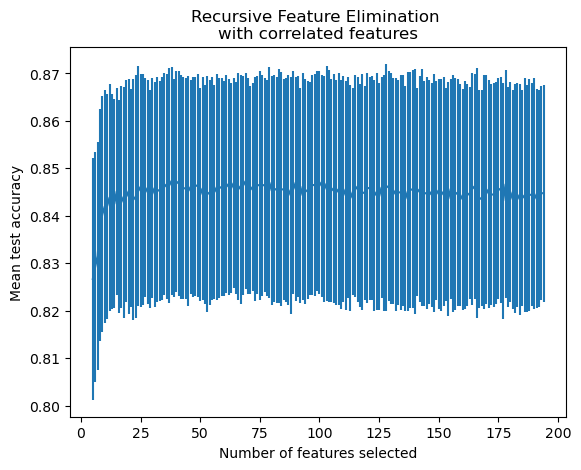

In [67]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [68]:
#Model4 （len(columns) descriptors）
Model4_clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)
Model4_clf.fit(X_XGB, y)
#Model4
Model4=Model_results(Model4_clf,X_XGB,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.851655,0.002488
Accuracy_train,0.967559,0.000293
F1 Score,0.652013,0.006904
Precision,0.771632,0.007023
Recall,0.570878,0.008886
Roc_auc,0.884855,0.002963


In [69]:
Model4_clf=Model4_clf.fit(X_XGB, y)
#Saving the final model
joblib.dump(Model4_clf, './XGB.pkl')
XGB= joblib.load(filename='./XGB.pkl')

In [70]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./XGB_model_data.csv",sep=',')
Model_data.columns = [['XGBoost']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./XGB_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method           XGBoost                                                    \
Model            Model 1             Model 2             Model 3             
Values              Mean        Se      Mean        Se      Mean        Se   
Accuracy_test   0.837037  0.002648  0.838484  0.002658  0.844466  0.002638   
Accuracy_train  0.985015  0.000124  0.985015  0.000124  0.982007  0.000166   
F1 Score        0.631588  0.006563  0.633966  0.006443  0.631377  0.006913   
Precision       0.714510  0.007137  0.720798  0.007544  0.760219  0.008021   
Recall          0.570683  0.007999  0.570695  0.007635  0.544701  0.007960   
Roc_auc         0.870746  0.003171  0.872909  0.003166  0.878118  0.003063   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.851655  0.002488  
Accuracy_train  0.967559  0.000293  
F1 Score        0.652013  0.006904  
Precision       0.771632  0.007023  
Recall          0.570878  0.008886  
Roc_auc         0.884855  0.002963